# Paths

In [34]:
# (COMPLETE) Insert the following paths 
dataset_path      = "../a3/flowers_classes-20250415T010641Z-001/flowers_classes/jpg"
models_path       = "models/"
tensorboard_path  = "tensorboard/"

# 1) Training

### Dataloader

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [36]:
from torch.utils.data import Subset
import scipy.io
import os
import torch

def load_Flowers17_dataset(dataset_path, dataset_split_file_path, my_transform):

    full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)
    
    mat = scipy.io.loadmat( dataset_split_file_path )

    train_ids = mat['trn1'][0] #  'tst1' or 'trn1' or 'val1' 
    val_ids = mat['val1'][0]   #  'tst1' or 'trn1' or 'val1' 
    test_ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1' 
    
    # Map filenames to indices
    image_paths = [os.path.basename(full_dataset.samples[i][0]) for i in range(len(full_dataset))]
    id_to_idx = {int(p.split("_")[1].split(".")[0]): i for i, p in enumerate(image_paths)}
    
    # Get indices for train/test
    train_indices = [id_to_idx[i] for i in train_ids if i in id_to_idx]
    val_indices = [id_to_idx[i] for i in val_ids if i in id_to_idx]
    test_indices = [id_to_idx[i] for i in test_ids if i in id_to_idx]
    
    # Create train and test subsets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)

    dataset = {'train':train_dataset, 'val':val_dataset, 'test':test_dataset}
    
    return dataset

def create_dataloader(dataset, batch_size):
    # Create DataLoaders
    train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(dataset['val']  , batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(dataset['test'] , batch_size=batch_size, shuffle=False)

    print(f'Dataset stats:')
    total = 0
    # Example of iterating through train loader
    for images, labels in train_loader:
        total = total + images.shape[0]  # Check batch shape and labels
    print(f' - Train: {total} images')
    total = 0
    # Example of iterating through train loader
    for images, labels in val_loader:
        total = total + images.shape[0]  # Check batch shape and labels
    print(f' - Val: {total} images')
    total = 0
    # Example of iterating through train loader
    for images, labels in test_loader:
        total = total + images.shape[0]
    print(f' - Test: {total} images')

    dataloader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    
    return dataloader

### Training functions

In [37]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.classifier.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

            writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
                                epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
            writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
                                    epoch )
            layer_id += 1


def plot_layers_googlenet(net, writer, epoch):
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
            writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, epoch)
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, epoch)
            if layer.weight.grad is not None:
                writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, epoch)
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.AdamW(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    suffix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+suffix )
        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers_googlenet( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        path = f'{models_path}{prefix}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

### Validation function

In [38]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# 2) Create model and Fine-Tuning process

In [39]:
import torchvision
from torchvision.models import alexnet, AlexNet_Weights

my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()

# INSERT HERE THE PATH FOR THE DATASET SPLIT FILE AND THE BATCH SIZE
dataset_split_file = "../a3/flowers_classes-20250415T010641Z-001/flowers_classes/datasplits.mat"
batch_size = 32

dataset = load_Flowers17_dataset(dataset_path, dataset_split_file, my_transform)
dataloader = create_dataloader(dataset, batch_size) 

Dataset stats:
 - Train: 680 images
 - Val: 340 images
 - Test: 340 images


Test the dataloaders

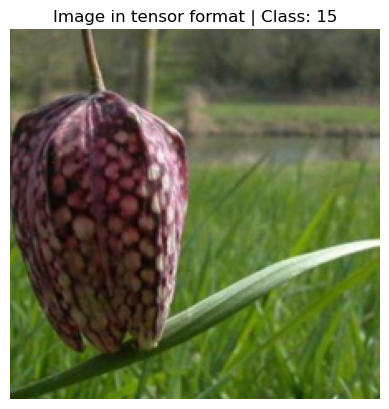

In [40]:
images, labels = next(iter(dataloader['train']))
my_tensor_image_show(images[0], label=labels[0])

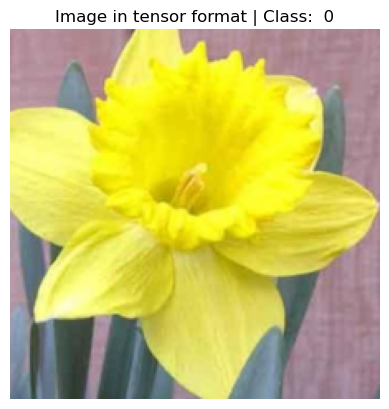

In [41]:
images, labels = next(iter(dataloader['test']))
my_tensor_image_show(images[0], label=labels[0])

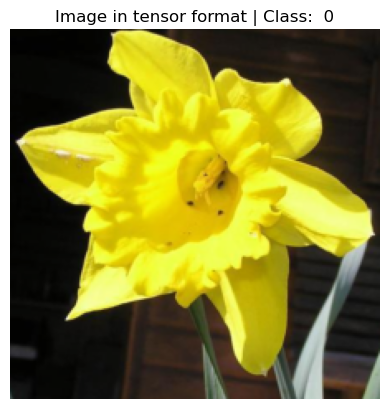

In [42]:
images, labels = next(iter(dataloader['val']))
my_tensor_image_show(images[0], label=labels[0])

In [43]:
# Execute only if necessarry to clear GPU memory

# del model # Verify if the model object exists

# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [44]:
# (COMPLETE) Create the model
import torchvision.models as models
import torch.nn as nn

googlenet_imagenet_weights = models.GoogLeNet_Weights.IMAGENET1K_V1

googlenet_transform = googlenet_imagenet_weights.transforms()

model = models.googlenet(weights=googlenet_imagenet_weights)

In [45]:
# (COMPLETE) Froze all parameters of the model and print the name of the layers
for param in model.parameters():
    param.requires_grad = False

for name, layer in model.named_modules():
        print(f'Layer: {name}')

Layer: 
Layer: conv1
Layer: conv1.conv
Layer: conv1.bn
Layer: maxpool1
Layer: conv2
Layer: conv2.conv
Layer: conv2.bn
Layer: conv3
Layer: conv3.conv
Layer: conv3.bn
Layer: maxpool2
Layer: inception3a
Layer: inception3a.branch1
Layer: inception3a.branch1.conv
Layer: inception3a.branch1.bn
Layer: inception3a.branch2
Layer: inception3a.branch2.0
Layer: inception3a.branch2.0.conv
Layer: inception3a.branch2.0.bn
Layer: inception3a.branch2.1
Layer: inception3a.branch2.1.conv
Layer: inception3a.branch2.1.bn
Layer: inception3a.branch3
Layer: inception3a.branch3.0
Layer: inception3a.branch3.0.conv
Layer: inception3a.branch3.0.bn
Layer: inception3a.branch3.1
Layer: inception3a.branch3.1.conv
Layer: inception3a.branch3.1.bn
Layer: inception3a.branch4
Layer: inception3a.branch4.0
Layer: inception3a.branch4.1
Layer: inception3a.branch4.1.conv
Layer: inception3a.branch4.1.bn
Layer: inception3b
Layer: inception3b.branch1
Layer: inception3b.branch1.conv
Layer: inception3b.branch1.bn
Layer: inception3b

In [46]:
# (COMPLETE) Replace the last layer to a new liner layer with the number of classes of your target problem. 
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=17)

In [47]:
# (COMPLETE) Free the parameters of specific layers to train.
for name, param in model.named_parameters():
    if 'inception5a' in  name or 'inception5b' in name:
        param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

inception5a.branch1.conv.weight True
inception5a.branch1.bn.weight True
inception5a.branch1.bn.bias True
inception5a.branch2.0.conv.weight True
inception5a.branch2.0.bn.weight True
inception5a.branch2.0.bn.bias True
inception5a.branch2.1.conv.weight True
inception5a.branch2.1.bn.weight True
inception5a.branch2.1.bn.bias True
inception5a.branch3.0.conv.weight True
inception5a.branch3.0.bn.weight True
inception5a.branch3.0.bn.bias True
inception5a.branch3.1.conv.weight True
inception5a.branch3.1.bn.weight True
inception5a.branch3.1.bn.bias True
inception5a.branch4.1.conv.weight True
inception5a.branch4.1.bn.weight True
inception5a.branch4.1.bn.bias True
inception5b.branch1.conv.weight True
inception5b.branch1.bn.weight True
inception5b.branch1.bn.bias True
inception5b.branch2.0.conv.weight True
inception5b.branch2.0.bn.weight True
inception5b.branch2.0.bn.bias True
inception5b.branch2.1.conv.weight True
inception5b.branch2.1.bn.weight True
inception5b.branch2.1.bn.bias True
inception5b.b

In [48]:
# (COMPLETE) Check layer parameters stats.
from torchinfo import summary

summary(model, input_size=(batch_size, 3, 224, 224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [32, 17]                  --
├─BasicConv2d: 1-1                       [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                  [32, 64, 112, 112]        (128)
├─MaxPool2d: 1-2                         [32, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [32, 64, 56, 56]          --
│    └─Conv2d: 2-3                       [32, 64, 56, 56]          (4,096)
│    └─BatchNorm2d: 2-4                  [32, 64, 56, 56]          (128)
├─BasicConv2d: 1-4                       [32, 192, 56, 56]         --
│    └─Conv2d: 2-5                       [32, 192, 56, 56]         (110,592)
│    └─BatchNorm2d: 2-6                  [32, 192, 56, 56]         (384)
├─MaxPool2d: 1-5                         [32, 192, 28, 28]         --
├─Inception: 1-6                         [32, 256, 28, 28] 

Training epochs...:   0%|          | 0/20 [00:00<?, ?it/s]

Training epochs...:   5%|▌         | 1/20 [00:56<17:50, 56.34s/it]

Saving Best Model with Accuracy:  65.88235294117646
Epoch:   1 | Accuracy : 65.8824%


Training epochs...:  10%|█         | 2/20 [01:52<16:52, 56.25s/it]

Saving Best Model with Accuracy:  84.11764705882354
Epoch:   2 | Accuracy : 84.1176%


Training epochs...:  15%|█▌        | 3/20 [02:51<16:20, 57.67s/it]

Saving Best Model with Accuracy:  89.11764705882354
Epoch:   3 | Accuracy : 89.1176%


Training epochs...:  20%|██        | 4/20 [03:48<15:12, 57.06s/it]

Saving Best Model with Accuracy:  90.29411764705883
Epoch:   4 | Accuracy : 90.2941%


Training epochs...:  25%|██▌       | 5/20 [04:49<14:41, 58.79s/it]

Saving Best Model with Accuracy:  91.17647058823529
Epoch:   5 | Accuracy : 91.1765%


Training epochs...:  30%|███       | 6/20 [05:53<14:06, 60.47s/it]

Saving Best Model with Accuracy:  91.47058823529412
Epoch:   6 | Accuracy : 91.4706%


Training epochs...:  35%|███▌      | 7/20 [06:57<13:20, 61.58s/it]

Saving Best Model with Accuracy:  91.76470588235294
Epoch:   7 | Accuracy : 91.7647%


Training epochs...:  40%|████      | 8/20 [08:03<12:35, 62.97s/it]

Saving Best Model with Accuracy:  92.94117647058823
Epoch:   8 | Accuracy : 92.9412%


Training epochs...:  45%|████▌     | 9/20 [09:08<11:39, 63.58s/it]

Saving Best Model with Accuracy:  93.23529411764706
Epoch:   9 | Accuracy : 93.2353%


Training epochs...:  50%|█████     | 10/20 [10:13<10:39, 64.00s/it]

Saving Best Model with Accuracy:  94.11764705882354
Epoch:  10 | Accuracy : 94.1176%


Training epochs...:  55%|█████▌    | 11/20 [11:17<09:37, 64.13s/it]

Epoch:  11 | Accuracy : 93.2353%


Training epochs...:  60%|██████    | 12/20 [12:22<08:35, 64.38s/it]

Epoch:  12 | Accuracy : 93.5294%


Training epochs...:  65%|██████▌   | 13/20 [13:29<07:34, 64.98s/it]

Epoch:  13 | Accuracy : 92.9412%


Training epochs...:  70%|███████   | 14/20 [14:35<06:32, 65.42s/it]

Epoch:  14 | Accuracy : 93.5294%


Training epochs...:  75%|███████▌  | 15/20 [15:41<05:28, 65.73s/it]

Epoch:  15 | Accuracy : 94.1176%


Training epochs...:  80%|████████  | 16/20 [16:56<04:33, 68.30s/it]

Epoch:  16 | Accuracy : 94.1176%


Training epochs...:  85%|████████▌ | 17/20 [18:12<03:32, 70.77s/it]

Saving Best Model with Accuracy:  94.70588235294117
Epoch:  17 | Accuracy : 94.7059%


Training epochs...:  90%|█████████ | 18/20 [19:26<02:23, 71.79s/it]

Epoch:  18 | Accuracy : 93.8235%


Training epochs...:  95%|█████████▌| 19/20 [20:46<01:14, 74.04s/it]

Epoch:  19 | Accuracy : 94.1176%


Training epochs...: 100%|██████████| 20/20 [22:03<00:00, 66.17s/it]

Epoch:  20 | Accuracy : 94.4118%
Model saved in: models/GoogLeNet-FT1-flowers-e-20-lr-0.0001-94.71.pkl


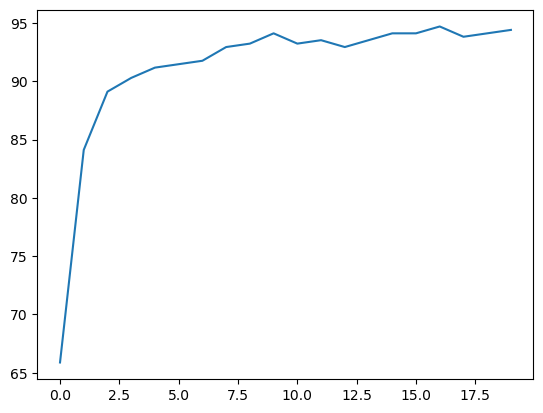

In [ ]:
# (COMPLETE) Set the device and transfer the model to it.
my_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(my_device)

# (COMPLETE) Set the train parameters
epochs = 20
lr = 1e-4
dataset_name = 'flowers'
prefix = 'GoogLeNet-FT1-{}-e-{}-lr-{}'.format(dataset_name, epochs, lr)

net = train(dataloader['train'], dataloader['val'], model, len(dataset['train']),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

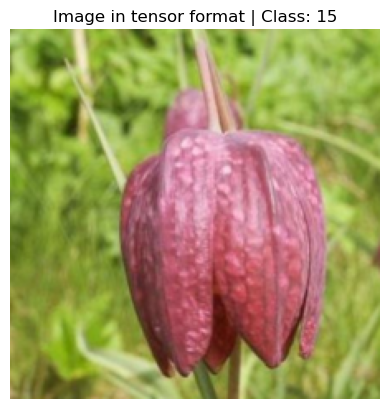

Sample id: 165
Hit
Predicted: 15 | Corrected: 15 | Confidence: 87.02%


In [ ]:
def sample_and_predict ( net, dataset, my_transform, seed=None ) :

    if seed is not None :
        np.random.seed(seed)
    
    my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(dataset['test']))
    
    sample, label = dataset['test'][i]
    
    my_tensor_image_show(sample, label=label)

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    # print(x.shape)

    x = x.unsqueeze_(0)
    # print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    if predicted_class == label : print('Hit')
    else: print('Miss')

    print( f"Predicted: {predicted_class} | Corrected: {label} | Confidence: {confidence*100:.2f}%"  )
    
    # return dataset_classes[y], dataset_classes[data[i][1]], confidence

sample_and_predict(net, dataset, my_transform)


In [51]:
test_accuracy = validate(net, dataloader['test'], my_device) 

print(f'Model accuracy on test split of the dataset: {test_accuracy:.2f}%')

Model accuracy on test split of the dataset: 95.29%


# 3) Image Retrieval

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

from tqdm import trange
import random

import scipy.io
import tqdm

### Image Display

In [53]:
def show_top_images ( dataset_path, indices , id_test , ids , labels ) :
    
    label = (ids[id_test] - 1) // 80

    name = dataset_path + '/jpg/' + str(label) + '/image_' + str(ids[id_test]).zfill(4) + '.jpg'
    image = Image.open( name )
    
    top = 0
    show_image_label(top, image, labels[id_test], ids[id_test] )
    
    accuracy = 0
    
    for i in indices[0] :
        label_i = labels[i]
        name = dataset_path + '/jpg/' + str(label_i) + '/image_' + str(ids[i]).zfill(4) + '.jpg'

        image = Image.open( name )

        show_image_label(top, image, label_i, ids[i] )   
        top = top + 1
        
    
def show_image_label ( top, image, label , image_id ) :
    
    plt.figure(figsize = (5,5))
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.title(f'{top} - Image id {image_id} with label {label}.')
    plt.show()

### Generate descriptors

In [54]:
def create_deep_descriptors (image, model, my_transform, my_device='cpu') :

    model_input = my_transform(image) 
    model_input = model_input.unsqueeze_(0)
    
    model = model.to(my_device)
    model_input = model_input.to(my_device)

    model.eval()
    with torch.no_grad():
        desc_deep = model(model_input).squeeze(0)
    
    return desc_deep.to('cpu')

### Data

In [55]:
def represent_dataset( dataset_path, model, my_transform, my_device ) :

    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1' 
    
    space = []
    labels = []
    
    for id in tqdm.tqdm(ids, desc='Processing test set') :

        label = (id - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id).zfill(4) + '.jpg'

        image = Image.open( name )
        
        if image is None:
            print(f'Reading image Error. Path: {name}')
            return None

        desc_deep = create_deep_descriptors(image, model, my_transform, my_device)

        space.append(desc_deep)
        labels.append(label)
        
    print( ' -> [I] Space Describing Info:\n', 
        '\nNumber of images: ', len(space), 
        '\nNumber of labels: ', len(labels),
        '\nDimension: ', len(space[0])
        )

    return space , labels 

In [56]:
from sklearn.neighbors import NearestNeighbors

def run_test ( space , labels , dataset_path, model, my_transform, my_device, top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1'
    
    accuracy_t = 0
    
    for id_test in tqdm.tqdm(ids, desc='running the test phase') :
        
        label = (id_test - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id_test).zfill(4) + '.jpg'

        image = Image.open( name )
        
        desc_deep = create_deep_descriptors(image, model, my_transform, my_device)

        indices = knn.kneighbors(desc_deep.reshape(1, -1))[1]

        labels_top = [ labels[i] for i in indices[0] ]

        accuracy = sum( np.equal(labels_top, label) )
        accuracy =( (accuracy-1)/(top) ) * 100
        accuracy_t = accuracy_t + accuracy
        
    print(f'Average accuracy in the test set: {accuracy_t/len(ids):5.2f}%')

### Experimental evaluation

In [57]:
def retrieve_single_image ( space , labels , dataset_path, model, my_transform, my_device, top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] 
    
    id_test = random.randrange( len(ids) )
        
    label = (ids[id_test] - 1) // 80
    name = dataset_path + '/jpg/' + str(label) + '/image_' + str(ids[id_test]).zfill(4) + '.jpg'
    
    image = Image.open( name )
    
    if image is None:
        print(f'Reading image Error. Path: {name}')
        return None

    desc_deep = create_deep_descriptors(image, model, my_transform, my_device)
    
    distances, indices = knn.kneighbors(desc_deep.reshape(1, -1))
    
    show_top_images(dataset_path, indices, id_test, ids, labels)
    
    labels_top = [ int(labels[i]) for i in indices[0] ]
    
    accuracy = sum( np.equal( label , labels_top ) )
    accuracy =( (accuracy-1)/(top) ) * 100 
    
    print(f'Accuracy for image id {ids[id_test]}: {accuracy:5.2f}%')
    
    print(name)    
    print(f'Image: {ids[id_test]} with label {labels[id_test]}')    
    print(f'Closest image: {ids[indices[0][0]]} with distance {distances[0][0]} and label {labels[indices[0][0]]}')
    print('Distances: ',distances)
    print('Indices: ',indices[0])
    print('Labels: ',labels_top)

### Create and load weights of the Descriptor model

In [62]:
# (COMPLETE) Create the model to describle the images based on the trained model
model.dropout = nn.Identity()
model.fc = nn.Identity()

# (COMPLETE) Instantiate the model_descriptor as an instance of the model to describe the images.
model_descriptor = copy.deepcopy(model)

# (COMPLETE) Create the transform object
my_transform = googlenet_imagenet_weights.transforms()

# (COMPLETE) Insert the path to the saved model.
weights_path = "models/GoogLeNet-FT1-flowers-e-20-lr-0.0001-94.71.pkl"

fine_tuning_weights = torch.load(weights_path, weights_only=False).state_dict()

# Load weights from fine-tuning AlexNet
model_descriptor.load_state_dict(fine_tuning_weights, strict=False)
model_descriptor.eval()

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")    
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

Running on cpu.


### Execution

In [63]:
# (COMPLETE) INSERT HERE YOUR DATASET PATH 
dataset_path_cbir = "../a3/flowers_classes-20250415T010641Z-001/flowers_classes"

# Using model descriptor, represent all images in the testing split of the dataset. 
space, labels = represent_dataset ( dataset_path_cbir , model_descriptor, my_transform, my_device )

Processing test set: 100%|██████████| 340/340 [00:29<00:00, 11.54it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  1024


In [64]:
# For each image of the testing split of the dataset, use the image as the query
# for the image retrieval problem, i.e., describe the image using the model descriptor, 
# and search for the k closest descriptors of the images in the testing split dataset. 
# After that, measure the accuracy of the image retrieval by counting how many of the k
# retrieved images has the same label of the query image, and divide it by k. 
# This result will be the accuracy of the image retrieval result for that specific image. 
# Repeat it for each image of the testing split of the dataset and compute the average of 
# all calculated accuracies.

run_test( space, labels, dataset_path_cbir, model_descriptor, my_transform, my_device )

running the test phase: 100%|██████████| 340/340 [00:30<00:00, 11.01it/s]

Average accuracy in the test set: 89.50%


In [ ]:
# For a random image of the testing split of the dataset, use the image as the query
# for the image retrieval problem, i.e., describe the image using the model descriptor, 
# and search for the k closest descriptors of the images in the testing split dataset. 
# After that, measure the accuracy of the image retrieval by counting how many of the k
# retrieved images has the same label of the query image, and divide it by k. 
# This result will be the accuracy of the image retrieval result for that specific image.
# Also display the query image, and all k images returned by the image retrieval problem.
# For each returned image, also display its class, and the Euclidean distance between its
# descriptor and the descriptor of the query image.
# Since the query image also is in the testing split of the dataset, it is expected that 
# the first returned image is the query image itself, and the distance between the 
# descriptors to be zero.

retrieve_single_image( space, labels, dataset_path_cbir, model_descriptor, my_transform, my_device)

Complete the table with the results from the run_test cell


#### Results:

| Model | Accuracy | Descriptor dim |
| :-- | --: | --: |
| Sift        | 20.94%  | 100  |
| Orb         | 18.03%  | 100  |
| Random      | 11.94%  | 100  |
| Grid 50x50  | 12.00%  | 100  |
| LBP         | 07.00%  | 100  |
| AlexNet     | 54.50%  | 4096 |
| VGG16       | 51.41%  | 4096 |
| GoogLeNet   | 56.82%  | 1024 |
| GoogLeNet FT| 89.50%  | 1024 |